First let's generate some data:

In [634]:
%matplotlib qt

In [635]:
import numpy
from colorsys import hsv_to_rgb
import matplotlib.pyplot as plt
from random import randint, random
from mpl_toolkits.mplot3d import Axes3D

In [727]:
class TransformationMatrix:
    def __init__(self, dimensions=2):
        self.dimensions = dimensions
        self.matrix = numpy.zeros((dimensions+1, dimensions+1))
        for x in range(dimensions+1):
            self.matrix[x,x] = 1
    def translate(self, *axes):
        sxes = axes[:self.dimensions]
        transmatrix = numpy.zeros((self.dimensions+1, self.dimensions+1))
        numpy.fill_diagonal(transmatrix, 1)
        for axis, axistranslation in enumerate(axes):
            transmatrix[axis,-1] += axistranslation
        self.matrix = self.matrix.dot(transmatrix)
    def randomise_3d(self):
        self.rotate_3d(random(), [random(), random(), random()])
        self.translate(random(), random(), random())
    def rotate_3d(self, theta, vector):
        vector = numpy.array(vector)/numpy.linalg.norm(vector)
        l = vector[0]
        m = vector[1]
        n = vector[2]
        cos_theta = numpy.cos(theta)
        sin_theta = numpy.sin(theta)
        self.matrix = self.matrix.dot(numpy.array([
            [
                l*l*(1-cos_theta) + cos_theta, 
                m*l*(1-cos_theta) - (n * sin_theta),
                n*l*(1-cos_theta) + (m * sin_theta),
                0
            ],
            [
                l*m*(1-cos_theta) + n * sin_theta,
                m*m*(1-cos_theta) + cos_theta,
                n*m*(1-cos_theta) - l*sin_theta,
                0
            ],
            [
                l*n*(1-cos_theta) - m*sin_theta,
                m*n*(1-cos_theta) + l*sin_theta,
                n*n*(1-cos_theta) + cos_theta,
                0
            ],
            [
                0,
                0,
                0,
                1
            ]
        ]))
    def rotate_3d_about(self, point, theta, axis):
        self.translate(*point)
        self.rotate_3d(theta, axis)
        self.translate(*[-x for x in point])
    def rotate_2d(self, theta, vector):
        x = vector[0]
        y = vector[1]
        cos_theta = numpy.cos(theta)
        sin_theta = numpy.sin(theta)
        self.matrix = self.matrix.dot(numpy.array(
            [[cos_theta, -sin_theta, x - (cos_theta*x) - (-sin_theta*y)],
             [sin_theta, cos_theta, y-(sin_theta*x) - (cos_theta*y)],
             [0,0,1]]).astype(numpy.float128))
        
        
t = TransformationMatrix(3)
t.rotate_3d(0.8,[1,0,0])
t.matrix

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.69670671, -0.71735609,  0.        ],
       [ 0.        ,  0.71735609,  0.69670671,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [791]:
class GSIndividual:
    def __init__(self, solver, param_values, parent=None):
        self.solver = solver
        self.param_values = param_values
        self.parent = parent
        self._fitness = None
    def fitness(self):
        if self._fitness is None:
            self._fitness = self.solver.function(*self.param_values)
        return self._fitness
    def fitness_gain(self):
        if self.parent is not None:
            return self.fitness() - self.parent.fitness()
        else:
            return self.fitness()

class GeneticSolver:
    def __init__(self, param_names, function, population_size=100):
        self.param_names = param_names
        self.pre_check = []
        self.function = function
        self.post_check = []
        self.population = []
        self.population_size = population_size
    def sample_uniform_hypercube(self, minimum, maximum, density):
        single_side = numpy.linspace(minimum, maximum, density)
        sample = []
        for param_values in product(*(single_side,)*len(self.param_names)):
            sample.append(GSIndividual(self, param_values))
        return sorted(sample, key=lambda x : -x.fitness_gain())[:self.population_size]

def testfunction(x=0, y=0):
    return 1 / (abs(x - 10) + abs(y+104)) + 0.00000000001

a = GeneticSolver(["tx", "ty"], testfunction)
[x.fitness_gain() for x in a.sample_uniform_hypercube(0,10,10)]

[0.0096153846253846167,
 0.0095137420818816078,
 0.0095137420818816078,
 0.0094142259514225952,
 0.0094142259514225952,
 0.0094142259514225952,
 0.0093167701963354048,
 0.0093167701963354048,
 0.0093167701963354031,
 0.0093167701963354031,
 0.0092213114854098367,
 0.0092213114854098367,
 0.0092213114854098367,
 0.0092213114854098367,
 0.009221311485409835,
 0.0091277890566531465,
 0.0091277890566531447,
 0.0091277890566531447,
 0.0091277890566531447,
 0.0091277890566531447,
 0.0091277890566531447,
 0.0090361445883132552,
 0.0090361445883132552,
 0.0090361445883132534,
 0.0090361445883132534,
 0.0090361445883132534,
 0.0090361445883132534,
 0.0090361445883132534,
 0.008946322077594434,
 0.008946322077594434,
 0.008946322077594434,
 0.008946322077594434,
 0.008946322077594434,
 0.008946322077594434,
 0.008946322077594434,
 0.008946322077594434,
 0.0088582677265354338,
 0.0088582677265354338,
 0.0088582677265354338,
 0.0088582677265354338,
 0.0088582677265354338,
 0.0088582677265354338,
 

In [770]:
class PointCloud:
    def __init__(self, dimensions=2):
        self.dimensions = dimensions
        self.points = numpy.zeros((0,self.dimensions+1))
        self.lines  = []
    def randomsetup(self, points=10, lines=10, size=1):
        self.add_points(numpy.random.randn(points,self.dimensions) * size)
        attempts = 0
        while len(self.lines) < lines and attempts < lines * 10:
            attempts += 1
            line = [randint(0,points-1), randint(0,points-1)]
            if line not in self.lines and line[::-1] not in self.lines and len(set(line)) == 2:
                self.lines.append(line)
    def add_points(self, coordinates):
        coordinates = numpy.pad(
            coordinates,
            pad_width= ((0,0),(0,1)), 
            mode="constant", 
            constant_values=1
        )
        self.points = numpy.append(self.points, coordinates, axis=0)
    def add_line(self, point1, point2):
        self.lines.append((point1, point2))
    def mutate(self, size=0.1):
        self.points[:,:3] += (numpy.random.randn(*self.points.shape) * size)[:,:3]
    def _plot_2d(self):
        for line_id, (point1, point2) in enumerate(self.lines):
            h = (line_id*0.5)/len(self.lines)
            coordinates_1 = self.points[point1,:]
            coordinates_2 = self.points[point2,:]
            plt.plot(
                [coordinates_1[0],coordinates_2[0]], 
                [coordinates_1[1],coordinates_2[1]], 
                color=hsv_to_rgb(h,1,1))
        plt.scatter(self.points[:,0],self.points[:,1])
        plt.axis('equal')
    def _plot_3d(self, *transformation_matrices):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        hues = numpy.linspace(0,0.8,self.points.shape[0])
        transformation_matrices = list(transformation_matrices)
        transformation_matrices.append(None)
        plottable = self.clone()
        for transformation_matrix, l in zip(transformation_matrices, numpy.linspace(1,0.1,len(transformation_matrices))):
            cols = [hsv_to_rgb(h,l,1) for h in hues]
            if transformation_matrix is not None:
                plottable.transform(transformation_matrix)
            ax.scatter(
                plottable.points[:,0], 
                plottable.points[:,1], 
                plottable.points[:,2], 
                 lw = 0,
                alpha=0.1,
                c=cols,
                s=50
            )
    def interpolate(self, other, l=0.5):
        interpolated = self.clone()
        interpolated.points = other.points * l + self.points * (1-l)
        return interpolated
    def plot_3d_transform(self, transformation, references=(), steps = 10):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        hues = numpy.linspace(0,0.8,self.points.shape[0])
        transformed = self.clone().transform(transformation)
        if len(references) > 0:
            a = 0.2
        else:
            a = 0.5
        for l in numpy.linspace(0,1,steps):
            interpolated = self.interpolate(transformed, l)
            cols = [hsv_to_rgb(h,(0.5+l/2),1) for h in hues]
            lw = 1 if l in [1,0] else 0
            ax.scatter(
                interpolated.points[:,0], 
                interpolated.points[:,1], 
                interpolated.points[:,2], 
                lw = lw,
                alpha=a,
                c=cols,
                s=50
            )
        for r in references:
            cols = [hsv_to_rgb(h,1,1) for h in hues]
            lw = 1 if l in [1,0] else 0
            ax.scatter(
                r.points[:,0], 
                r.points[:,1], 
                r.points[:,2], 
                lw = 1,
                alpha=0.8,
                c=cols,
                s=100
            )
    def paired_3d_align(self, other, inv=True):
        # inv = True  - move this pointcloud to the other
        #       False - move the other pointcloud to this
        if inv:
            return solve_3d_transformation(self, other)
        else:
            return solve_3d_transformation(other, self)
    def n_points(self):
        return self.points.shape[0]
    def unpaired_3d_rmse(self, other):
        if self.n_points < other.n_points:
            shorter = self
            longer = other
        else:
            longer = self
            shorter = other
        return distance.cdist(longer, shorter).min(axis=0).mean()
    def centroid(self):
        return numpy.mean(self.points, axis=0)
    def bounding_box(self, extent=True):
        mins = self.points.min(axis=0)
        maxs = self.points.max(axis=0)
        if extent:
            centroid = self.centroid()
            return mins-centroid, maxs-centroid
        else:
            return mins, maxs
    def unpaired_3d_align(self, other, weights={}, centre="centroid", pin=None, r_init = 10):
        # Use genetic algorithm to solve
        # First compute centroid. Pin will force two points together
        if centre == "centroid":
            self_centroid = self.centroid
            other_centroid = other.centroid
        elif centre == "pin" and pin is not None:
            self_centroid = self.points[pin[0],:]
            other_centroid = self.points[pin[1],:]
        elif centre == "wander":
            self_centroid = self.centroid
            other_centroid = other.centroid
        # Now we have either 3 parameters to optimise
        # For all:
        #    rx, ry, rz
        # For unpinned AND numbers differing:
        diff_n_points = numpy.abs(self.n_points() - other.n_points())
        optimise_transform = pin is None and diff_n_points > 0
        #    tx, ty, tz
        # First we generate 10*10*10 starting rotations
        start_rotations = numpy.linspace(0,2*numpy.pi,r_init)        
    def plot(self, *args):
        if self.dimensions == 2:
            self._plot_2d()
        if self.dimensions == 3:
            self._plot_3d(*args)
    def transform(self, transformation_matrix):
        self.points = self.points.astype(numpy.float64)
        self.points = self.points.dot(transformation_matrix.matrix.T)
        return self
    def clone(self):
        clone = PointCloud(self.dimensions)
        clone.points = self.points
        clone.lines = self.lines
        return clone

In [773]:
numpy.min([[1,2,3],[0,2,5]], axis=0)

array([0, 2, 3])

<IPython.core.display.Javascript object>


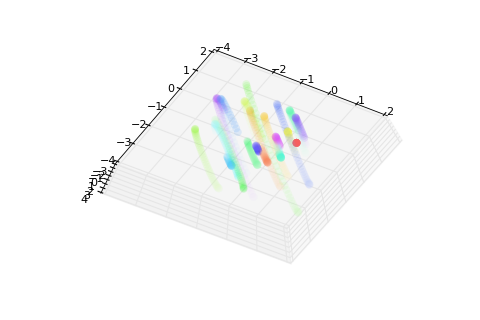

In [638]:
%matplotlib qt
a = PointCloud(3)
a.randomsetup(lines=5, points=20, size=1)
t = TransformationMatrix(3)
t.rotate_3d_about(a.points[0], numpy.pi/40,[0.72,0.72,0])
a.plot(*(t,)*40)


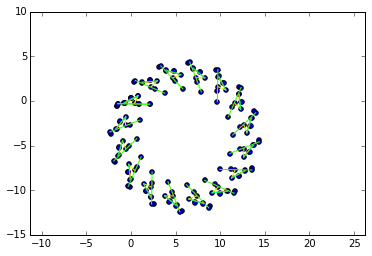

In [316]:
%matplotlib inline
a = PointCloud(dimensions = 2)
t = TransformationMatrix()

t.translate(2,2)
t.rotate_2d(-numpy.pi/8,[0,0])
a.randomsetup(lines=5, points=10)
a.plot()
for _ in range(16):
    a.transform(t)
    a.plot()

<IPython.core.display.Javascript object>


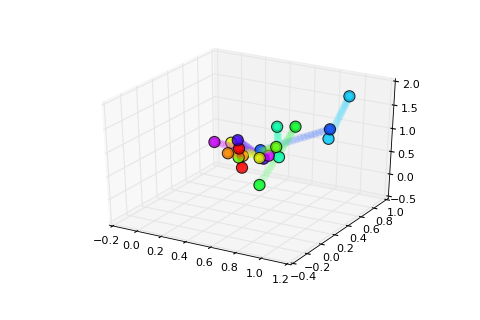

In [639]:
def pairwise_rmse(points1, points2):
    return numpy.sqrt((numpy.square(points1 - points2)).mean())

def solve_3d_transformation(operand, reference, subselection=None, test=True):
    if subselection is None:
        operand_points = numpy.mat(operand.points[:,:3])
        reference_points = numpy.mat(reference.points[:,:3])
    else:
        operand_points = numpy.mat(operand.points[subselection,:3])
        reference_points = numpy.mat(reference.points[subselection,:3])
    assert len(operand_points) == len(reference_points)

    n_points = operand_points.shape[0]

    operand_centroid = numpy.mean(operand_points, axis=0)
    reference_centroid = numpy.mean(reference_points, axis=0)
    
    # centre the points
    operand_centred   = operand_points - numpy.tile(operand_centroid, (n_points, 1))
    reference_centred   = reference_points - numpy.tile(reference_centroid, (n_points, 1))

    # dot is matrix multiplication for array
    covariance_matrix = numpy.transpose(operand_centred) * reference_centred

    unitary_matrix, diagonal_matrix, unitary_over_field = numpy.linalg.svd(covariance_matrix)

    rotation_matrix = unitary_over_field.T * unitary_matrix.T
    # special reflection case
    if numpy.linalg.det(rotation_matrix) < 0:
       unitary_over_field[2,:] *= -1
       rotation_matrix = unitary_over_field.T * unitary_matrix.T
    translation_vector = -rotation_matrix*operand_centroid.T + reference_centroid.T

    rotation_matrix = numpy.pad(
            rotation_matrix, 
            pad_width = ((0,1),(0,1)), 
            mode="constant", 
            constant_values=0)
    rotation_matrix[3,3] = 1


    translation_matrix = numpy.zeros((4,4))
    numpy.fill_diagonal(translation_matrix, 1)
    translation_matrix[:3,3:] = translation_vector
    

    transformation_matrix = TransformationMatrix(3)
    transformation_matrix.matrix = translation_matrix.dot(rotation_matrix)

    if test:
        operand_4d =numpy. pad(
            operand_points,
            pad_width= ((0,0),) * (1) + ((0,1),), 
            mode="constant", 
            constant_values=1
        )
        #transformed_operand = operand_4d.dot(transformation_matrix.matrix.T)[:,:3]
        transformed_operand = operand.clone()
        transformed_operand.transform(transformation_matrix)
        rmse = pairwise_rmse(transformed_operand.points[:,:3], reference.points[:,:3])
        #print(rmse)
        return transformation_matrix, rmse, transformed_operand
tm, rmse, tr = solve_3d_transformation(ap, bp)
#ap.plot()
#bp.plot()
sol = ap.clone()
sol.plot_3d_transform(tm, steps=20, references=[ap, bp])

6.22436562875e-16


<IPython.core.display.Javascript object>


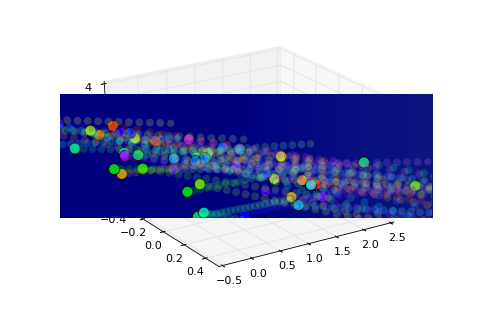

In [733]:
%matplotlib qt
''''''
ref_points = PointCloud(3)
ref_points.randomsetup(lines=0, points=50)
t = TransformationMatrix(3)
t.randomise_3d()
t.randomise_3d()
t.randomise_3d()
op_points = ref_points.clone()
op_points.transform(t)
#op_points.mutate()
''''''
tm, rmse, aligned = solve_3d_transformation(op_points, ref_points)
print(rmse)
op_points.plot_3d_transform(tm, steps=20, references=[ref_points])


{'subsel': [37, 35, 36, 39, 9, 28, 14, 26, 4, 7], 'aligned': <__main__.PointCloud instance at 0x7f446216f998>, 'tm': <__main__.TransformationMatrix instance at 0x7f446216fa70>, 'rmse': 2.2882459854810165e-16}
{'subsel': [38, 10, 28], 'aligned': <__main__.PointCloud instance at 0x7f4462167248>, 'tm': <__main__.TransformationMatrix instance at 0x7f4462167128>, 'rmse': 4.2496436612039858e-15}


<IPython.core.display.Javascript object>


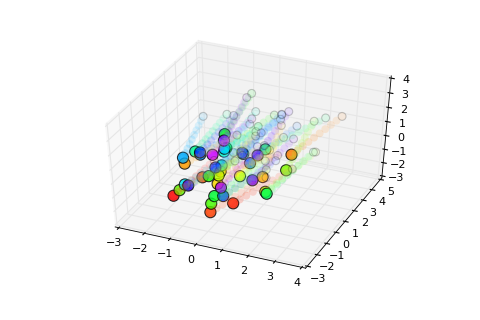

2.28824598548e-16


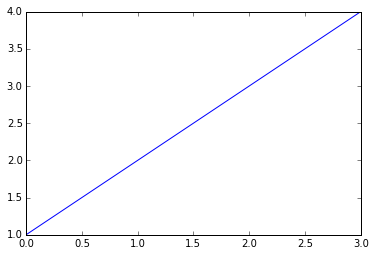

In [591]:
%matplotlib inline
plt.plot([1,2,3,4])

In [704]:
ap = PointCloud(3)
bp = PointCloud(3)

pa = numpy.array([[ 0.26832805,  0.57129996,  0.05275835],
 [ 0.14437605,  0.79728663,  0.0503873 ],
 [ 0.03560124,  0.81480421,  0.27551898],
 [ 0.26079327 , 0.53683492 , 0.30887791],
 [ 0.68142564 , 0.1024622 ,  0.32793634],
 [ 0.53706422 , 0.63448485 , 0.37119874],
 [ 0.91510412 , 0.6630108 ,  0.93860456],
 [ 0.49826643 , 0.43610394 , 0.68186992],
 [ 0.33901613 , 0.76119177 , 0.11922139],
 [ 0.28837246 , 0.92693572 , 0.01138285]])

pb = numpy.array([[ 0.57232678 , 0.01149324 , 1.13154136],
 [ 0.61665812, -0.21100935,  1.25388114],
 [ 0.86457814, -0.21766888 , 1.29013596],
 [ 0.80088173, 0.11991548 , 1.18491826],
 [ 0.63891594 , 0.68518925 , 1.04276649],
 [ 0.71350129 , 0.28620612 , 1.41827874],
 [ 1.0197748 ,  0.75158067 , 1.81236037],
 [ 1.01520482 , 0.48747756 , 1.34184818],
 [ 0.58342516, -0.0235825  , 1.34158791],
 [ 0.50396425 ,-0.1964217 ,  1.41559847]])
ap.add_points(pa)
bp.add_points(pb)

In [705]:
solve_3d_transformation(ap, bp)

(<__main__.TransformationMatrix instance at 0x7f446f19b170>,
 3.4077959472498144e-09,
 <__main__.PointCloud instance at 0x7f4463224680>)

<IPython.core.display.Javascript object>


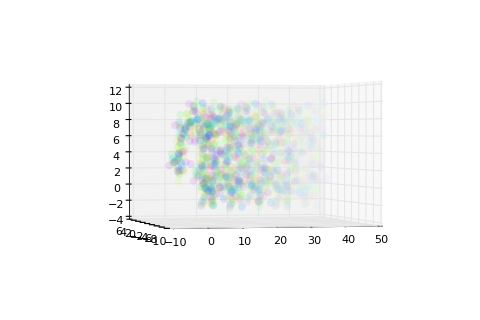

(<__main__.TransformationMatrix instance at 0x7f4462337b00>,
 7.0194723232735267e-16,
 <__main__.PointCloud instance at 0x7f4462337cf8>)

In [724]:
ref_points = PointCloud(3)
ref_points.randomsetup(lines=0, points=40)
t = TransformationMatrix(3)
t.translate(1,2,3)
t.rotate_3d(0.85,[1,0,0])
#t.randomise_3d()
#t.randomise_3d()
op_points = ref_points.clone()
op_points.transform(t)
ref_points.plot(*(t,t)*20)
#op_points.mutate()
solve_3d_transformation(ref_points, op_points)

In [735]:
from scipy.spatial import distance

In [742]:
shorter = pa[:5,:]
longer = pa

In [749]:
distance.cdist(shorter, longer).min(axis=1).mean()

0.0

In [769]:
pa.min(axis=0)

array([ 0.03560124,  0.1024622 ,  0.01138285])